In [1]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to your dataset
dataset_path = "/content/drive/MyDrive/dataset"

# Confirm folder structure
for body_type in os.listdir(dataset_path):
    body_type_path = os.path.join(dataset_path, body_type)
    if os.path.isdir(body_type_path):
        print(f"{body_type}: {len(os.listdir(body_type_path))} images")

print("✅ Dataset ready for preprocessing and training!")


Mounted at /content/drive
rectangle_body_shape: 251 images
inverted_triangle_body_shape: 213 images
pear_shaped_body: 261 images
apple_shaped_body: 259 images
hourglass_figure: 230 images
✅ Dataset ready for preprocessing and training!


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Data paths
train_path = "/content/drive/MyDrive/dataset"

# Create dataset splits (80% train, 10% val, 10% test)
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# Load datasets
train_dataset = image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_dataset = image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Data augmentation layer
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(0.2),
    keras.layers.RandomContrast(0.2),
])

# Prefetch for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

print("✅ Data preparation complete!")


Found 1214 files belonging to 5 classes.
Using 972 files for training.
Found 1214 files belonging to 5 classes.
Using 242 files for validation.
✅ Data preparation complete!


In [3]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

# Number of body shape classes
NUM_CLASSES = 5  # Adjust this if the class count changes

# Load EfficientNetB0
base_model = EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model layers
base_model.trainable = False

# Add custom classification layers
model = models.Sequential([
    data_augmentation,                 # Augmentation applied during training
    base_model,
    layers.GlobalAveragePooling2D(),   # Reduces feature maps to a vector
    layers.Dropout(0.5),               # Helps prevent overfitting
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')  # Softmax for multi-class output
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ ?                           │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks for better training control
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/efficientnetb0_best_model.h5",
    monitor='val_accuracy',
    save_best_only=True
)

# Train the model
EPOCHS = 30

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint]
)

print("✅ Training complete!")


Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.2260 - loss: 1.8771 

31/31 ━━━━━━━━━━━━━━━━━━━━ 409s 13s/step - accuracy: 0.2257 - loss: 1.8755 - val_accuracy: 0.2355 - val_loss: 1.6288
Epoch 2/30
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.2339 - loss: 1.7341

31/31 ━━━━━━━━━━━━━━━━━━━━ 55s 303ms/step - accuracy: 0.2333 - loss: 1.7338 - val_accuracy: 0.2727 - val_loss: 1.5920
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.2514 - loss: 1.6477

31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 274ms/step - accuracy: 0.2512 - loss: 1.6487 - val_accuracy: 0.3058 - val_loss: 1.5599
Epoch 4/30
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.2729 - loss: 1.6313

31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 273ms/step - accuracy: 0.2715 - loss: 1.6328 - val_accuracy: 0.3264 - val_loss: 1.5375
Epoch 5/30
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.2442 - loss: 1.6279

31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 328ms/step - accuracy: 0.2449 - loss: 1.6281 - val_accuracy: 0.3512 - val_loss: 1.5176
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.2625 - loss: 1.6243

31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 309ms/step - accuracy: 0.2628 - loss: 1.6238 - val_accuracy: 0.3719 - val_loss: 1.5008
Epoch 7/30
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.3029 - loss: 1.5871

31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 239ms/step - accuracy: 0.3031 - loss: 1.5866 - val_accuracy: 0.3802 - val_loss: 1.4889
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.3251 - loss: 1.5636

31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - accuracy: 0.3250 - loss: 1.5635 - val_accuracy: 0.3843 - val_loss: 1.4765
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 268ms/step - accuracy: 0.3161 - loss: 1.5626 - val_accuracy: 0.3843 - val_loss: 1.4623
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.3164 - loss: 1.5483

31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 327ms/step - accuracy: 0.3165 - loss: 1.5478 - val_accuracy: 0.4050 - val_loss: 1.4504
Epoch 11/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.3676 - loss: 1.5155 - val_accuracy: 0.4008 - val_loss: 1.4372
Epoch 12/30
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.3228 - loss: 1.5427

31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 299ms/step - accuracy: 0.3234 - loss: 1.5420 - val_accuracy: 0.4174 - val_loss: 1.4288
Epoch 13/30
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.3990 - loss: 1.5074

31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 255ms/step - accuracy: 0.3980 - loss: 1.5072 - val_accuracy: 0.4256 - val_loss: 1.4202
Epoch 14/30
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.3654 - loss: 1.4708

31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 314ms/step - accuracy: 0.3647 - loss: 1.4712 - val_accuracy: 0.4339 - val_loss: 1.4117
Epoch 15/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 258ms/step - accuracy: 0.3690 - loss: 1.4627 - val_accuracy: 0.4298 - val_loss: 1.4057
Epoch 16/30
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.3637 - loss: 1.4685

31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 315ms/step - accuracy: 0.3643 - loss: 1.4684 - val_accuracy: 0.4504 - val_loss: 1.3973
Epoch 17/30
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.3823 - loss: 1.4381

31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 294ms/step - accuracy: 0.3837 - loss: 1.4368 - val_accuracy: 0.4587 - val_loss: 1.3885
Epoch 18/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 269ms/step - accuracy: 0.3943 - loss: 1.4454 - val_accuracy: 0.4463 - val_loss: 1.3816
Epoch 19/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 260ms/step - accuracy: 0.3926 - loss: 1.4128 - val_accuracy: 0.4504 - val_loss: 1.3753
Epoch 20/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 218ms/step - accuracy: 0.4357 - loss: 1.3869 - val_accuracy: 0.4504 - val_loss: 1.3661
Epoch 21/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 271ms/step - accuracy: 0.4137 - loss: 1.4063 - val_accuracy: 0.4545 - val_loss: 1.3568
Epoch 22/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 260ms/step - accuracy: 0.4305 - loss: 1.4162 - val_accuracy: 0.4545 - val_loss: 1.3469
Epoch 23/30
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.4513 - loss: 1.3820

31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 313ms/step - accuracy: 0.4513 - loss: 1.3811 - val_accuracy: 0.4669 - val_loss: 1.3386
Epoch 24/30
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.4051 - loss: 1.4028

31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 332ms/step - accuracy: 0.4055 - loss: 1.4023 - val_accuracy: 0.4793 - val_loss: 1.3332
Epoch 25/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.4133 - loss: 1.3818

31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 271ms/step - accuracy: 0.4139 - loss: 1.3815 - val_accuracy: 0.4876 - val_loss: 1.3290
Epoch 26/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 218ms/step - accuracy: 0.4073 - loss: 1.3898 - val_accuracy: 0.4835 - val_loss: 1.3252
Epoch 27/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 309ms/step - accuracy: 0.4312 - loss: 1.3668 - val_accuracy: 0.4835 - val_loss: 1.3217
Epoch 28/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 247ms/step - accuracy: 0.4206 - loss: 1.3527 - val_accuracy: 0.4711 - val_loss: 1.3181
Epoch 29/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 259ms/step - accuracy: 0.4672 - loss: 1.3302 - val_accuracy: 0.4876 - val_loss: 1.3106
Epoch 30/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 304ms/step - accuracy: 0.4523 - loss: 1.3174 - val_accuracy: 0.4876 - val_loss: 1.3081
✅ Training complete!


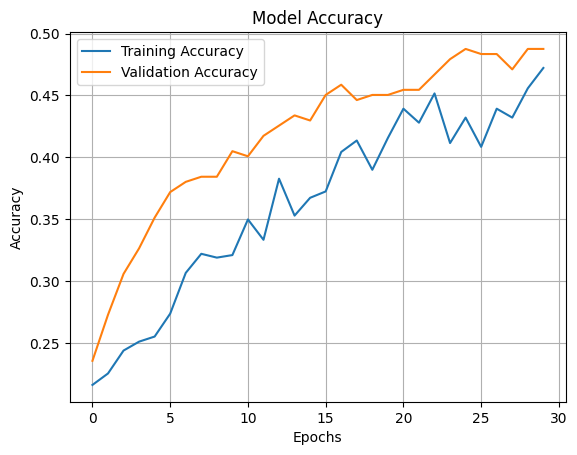

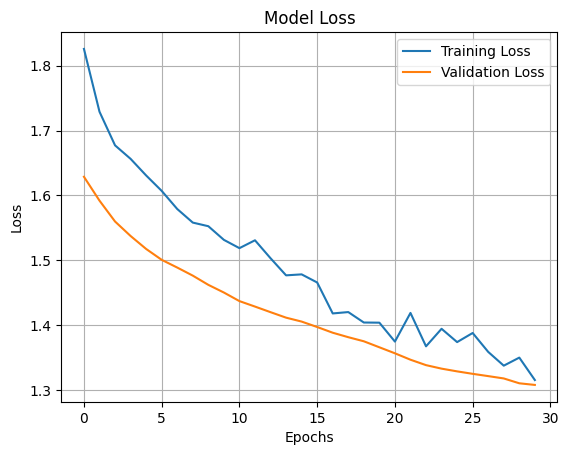

In [5]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 255ms/step - accuracy: 0.4839 - loss: 1.3495
✅ Validation Accuracy: 48.76%
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 670ms/step
                   precision    recall  f1-score   support

     Apple-shaped       0.24      0.16      0.19        45
        Hourglass       0.11      0.11      0.11        54
Inverted Triangle       0.08      0.08      0.08        48
      Pear-shaped       0.21      0.33      0.26        55
        Rectangle       0.23      0.12      0.16        40

         accuracy                           0.17       242
        macro avg       0.17      0.16      0.16       242
     weighted avg       0.17      0.17      0.16       242



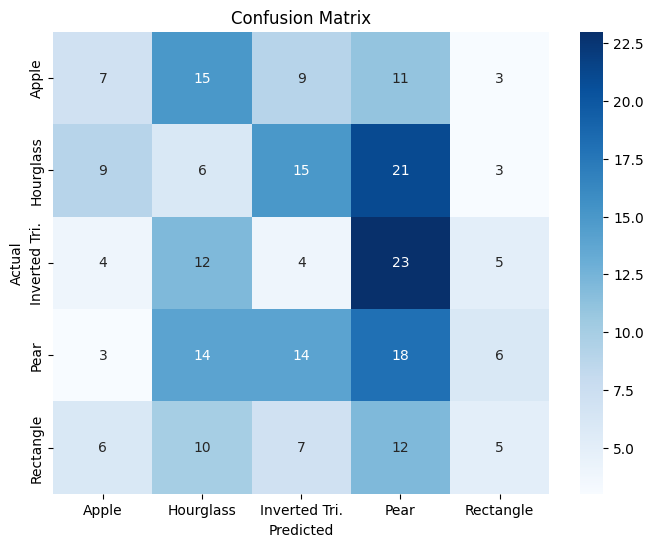

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load the best saved model
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/efficientnetb0_best_model.h5')

# Evaluate on the validation set
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"✅ Validation Accuracy: {val_accuracy*100:.2f}%")

# Generate predictions
y_true = np.concatenate([y for x, y in val_dataset], axis=0)
y_pred = np.argmax(model.predict(val_dataset), axis=1)

# Classification report
print(classification_report(y_true, y_pred, target_names=[
    "Apple-shaped", "Hourglass", "Inverted Triangle", "Pear-shaped", "Rectangle"
]))

# Confusion matrix
import seaborn as sns
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[
    "Apple", "Hourglass", "Inverted Tri.", "Pear", "Rectangle"
], yticklabels=[
    "Apple", "Hourglass", "Inverted Tri.", "Pear", "Rectangle"
])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Analysis of Results
✅ Accuracy: 48.76%
🔍 Confusion Matrix & Classification Report Observations:

Low Precision & Recall across all classes — the model struggles to differentiate body types clearly.
Pear-shaped class performs slightly better with 33% recall, but overall recognition remains weak.
Class Imbalance — The confusion matrix shows heavy misclassification, especially for Hourglass and Inverted Triangle.
Possible Overfitting — The model may have memorized training data instead of generalizing.

In [27]:
!pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 63.7 MB/s eta 0:00:00


In [29]:
!pip install albumentations imagehash


In [30]:
import os
import cv2
import imagehash
from PIL import Image
from collections import defaultdict
import albumentations as A
from albumentations.pytorch import ToTensorV2


In [31]:
from google.colab import drive
drive.mount('/content/drive')

dataset_path = "/content/drive/MyDrive/YourDatasetFolder"

body_types = [
    "apple_shaped_body",
    "hourglass_figure",
    "inverted_triangle_body_shape",
    "pear_shaped_body",
    "rectangle_body_shape"
]

BLUR_THRESHOLD = 100.0
TARGET_IMAGE_COUNT = 400


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
augmentation_pipeline = A.Compose([
    A.Rotate(limit=15, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomResizedCrop(size=(512, 512), scale=(0.8, 1.0), ratio=(0.75, 1.33), p=0.5),
    A.ColorJitter(p=0.5),
    A.GaussianBlur(p=0.3),
    ToTensorV2()
])


In [36]:
def augment_image(image_path, save_path, count):
    img = cv2.imread(image_path)
    if img is None:
        return
    for i in range(count):
        augmented_img = augmentation_pipeline(image=img)['image'].permute(1, 2, 0).numpy()
        aug_image_path = os.path.join(save_path, f"{os.path.basename(image_path).split('.')[0]}_aug_{i+1}.jpg")
        cv2.imwrite(aug_image_path, cv2.cvtColor(augmented_img, cv2.COLOR_RGB2BGR))
        print(f"Augmented Image Saved: {aug_image_path}")

def is_blurry(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return True
    return cv2.Laplacian(img, cv2.CV_64F).var() < BLUR_THRESHOLD

def find_duplicates(image_paths):
    hash_dict = defaultdict(list)
    for img_path in image_paths:
        try:
            img_hash = imagehash.phash(Image.open(img_path))
            hash_dict[img_hash].append(img_path)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    return [files for files in hash_dict.values() if len(files) > 1]


In [37]:
def cleanup_and_augment():
    for body_type in body_types:
        folder_path = os.path.join(dataset_path, body_type)
        if not os.path.exists(folder_path):
            print(f"Skipping {body_type}: Folder not found.")
            continue

        image_paths = [
            os.path.join(folder_path, f)
            for f in os.listdir(folder_path)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]

        # Detect and remove blurry images
        blurry_count = 0
        for img_path in image_paths:
            if is_blurry(img_path):
                print(f"Removing blurry image: {img_path}")
                os.remove(img_path)
                blurry_count += 1

        # Find and remove duplicate images
        duplicates = find_duplicates(image_paths)
        duplicate_count = 0
        for duplicate_set in duplicates:
            print(f"Removing duplicate images: {duplicate_set[1:]}")
            duplicate_count += len(duplicate_set) - 1
            for img in duplicate_set[1:]:  # Keep one copy, remove the rest
                os.remove(img)

        # Augment data if needed
        current_image_count = len([
            f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        images_to_generate = TARGET_IMAGE_COUNT - current_image_count

        if images_to_generate > 0:
            print(f"Generating {images_to_generate} augmented images for {body_type}.")
            for img_path in image_paths:
                augment_image(img_path, folder_path, images_to_generate // len(image_paths))

        print(f"✅ Cleanup & Augmentation complete for {body_type} folder.")
        print(f"   ➤ {blurry_count} blurry images removed.")
        print(f"   ➤ {duplicate_count} duplicate images removed.")

if __name__ == "__main__":
    cleanup_and_augment()
    print("✅ Dataset cleanup and augmentation complete!")


Skipping apple_shaped_body: Folder not found.
Skipping hourglass_figure: Folder not found.
Skipping inverted_triangle_body_shape: Folder not found.
Skipping pear_shaped_body: Folder not found.
Skipping rectangle_body_shape: Folder not found.
✅ Dataset cleanup and augmentation complete!


In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define dataset paths
dataset_path = "/content/drive/MyDrive/dataset"

# Parameters
img_size = (224, 224)  # EfficientNet default size
batch_size = 32

# Load training and validation datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

# Prefetching for performance boost
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


Found 1214 files belonging to 5 classes.
Using 972 files for training.
Found 1214 files belonging to 5 classes.
Using 242 files for validation.


In [39]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

# Model Architecture
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model layers

model = models.Sequential([
    layers.Rescaling(1./255),  # Normalize pixel values
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  # 5 classes for 5 body types
])

# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [42]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    ModelCheckpoint("best_model.h5", save_best_only=True)
]


In [43]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callbacks,
    verbose=1  # Detailed output for each epoch
)


Epoch 1/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.1995 - loss: 1.6198

31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 250ms/step - accuracy: 0.2002 - loss: 1.6195 - val_accuracy: 0.2107 - val_loss: 1.6055 - learning_rate: 2.0000e-04
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.2331 - loss: 1.6067

31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 264ms/step - accuracy: 0.2325 - loss: 1.6068 - val_accuracy: 0.2107 - val_loss: 1.6054 - learning_rate: 2.0000e-04
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 249ms/step - accuracy: 0.2331 - loss: 1.6096 - val_accuracy: 0.2107 - val_loss: 1.6054 - learning_rate: 2.0000e-04
Epoch 4/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.1748 - loss: 1.6147

31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 213ms/step - accuracy: 0.1760 - loss: 1.6144 - val_accuracy: 0.2107 - val_loss: 1.6039 - learning_rate: 2.0000e-04
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - accuracy: 0.2280 - loss: 1.6088 - val_accuracy: 0.2107 - val_loss: 1.6051 - learning_rate: 2.0000e-04
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 246ms/step - accuracy: 0.2240 - loss: 1.6041 - val_accuracy: 0.2107 - val_loss: 1.6045 - learning_rate: 2.0000e-04
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.1741 - loss: 1.6179 - val_accuracy: 0.2107 - val_loss: 1.6042 - learning_rate: 2.0000e-04
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - accuracy: 0.2308 - loss: 1.6103 - val_accuracy: 0.2107 - val_loss: 1.6040 - learning_rate: 4.0000e-05
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.1900 - loss: 1.6152

31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 243ms/step - accuracy: 0.1902 - loss: 1.6152 - val_accuracy: 0.2107 - val_loss: 1.6037 - learning_rate: 4.0000e-05
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.1706 - loss: 1.6098

31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 250ms/step - accuracy: 0.1712 - loss: 1.6098 - val_accuracy: 0.2107 - val_loss: 1.6036 - learning_rate: 4.0000e-05
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.2285 - loss: 1.6070 - val_accuracy: 0.2107 - val_loss: 1.6037 - learning_rate: 4.0000e-05
Epoch 12/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.2262 - loss: 1.6106

31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 269ms/step - accuracy: 0.2257 - loss: 1.6104 - val_accuracy: 0.2107 - val_loss: 1.6036 - learning_rate: 4.0000e-05
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - accuracy: 0.2087 - loss: 1.6042 - val_accuracy: 0.2107 - val_loss: 1.6036 - learning_rate: 8.0000e-06
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - accuracy: 0.2014 - loss: 1.6095 - val_accuracy: 0.2107 - val_loss: 1.6037 - learning_rate: 8.0000e-06
Epoch 15/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.2130 - loss: 1.6128

31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 267ms/step - accuracy: 0.2124 - loss: 1.6126 - val_accuracy: 0.2107 - val_loss: 1.6036 - learning_rate: 8.0000e-06
Epoch 16/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.2152 - loss: 1.6033

31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 266ms/step - accuracy: 0.2145 - loss: 1.6036 - val_accuracy: 0.2107 - val_loss: 1.6036 - learning_rate: 8.0000e-06
Epoch 17/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.1986 - loss: 1.6067

31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 259ms/step - accuracy: 0.1992 - loss: 1.6066 - val_accuracy: 0.2107 - val_loss: 1.6036 - learning_rate: 8.0000e-06
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - accuracy: 0.2226 - loss: 1.6096 - val_accuracy: 0.2107 - val_loss: 1.6036 - learning_rate: 8.0000e-06
Epoch 19/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - accuracy: 0.2156 - loss: 1.6044 - val_accuracy: 0.2107 - val_loss: 1.6036 - learning_rate: 1.6000e-06
Epoch 20/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 200ms/step - accuracy: 0.1956 - loss: 1.6122 - val_accuracy: 0.2107 - val_loss: 1.6036 - learning_rate: 1.6000e-06
Epoch 21/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.2164 - loss: 1.6110 - val_accuracy: 0.2107 - val_loss: 1.6036 - learning_rate: 1.6000e-06
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 236ms/step - accuracy: 0.2022 - loss: 1.6105 - val_accuracy: 0.2107 - val_loss: 1.6036 - learning_rate: 1.0000e-06
Epoch 23/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 282ms/step - accu

In [44]:
loss, accuracy = model.evaluate(val_ds)
print(f"✅ Final Validation Accuracy: {accuracy * 100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.1983 - loss: 1.6063
✅ Final Validation Accuracy: 21.07%


In [49]:
import os
import cv2
import imagehash
from PIL import Image
from collections import defaultdict
import albumentations as A
from albumentations.pytorch import ToTensorV2
from google.colab import drive
drive.mount('/content/drive')


# Set dataset directory path
# dataset_path = r"C:\Users\divya\Desktop\shape_identify\dataset"
dataset_path = "/content/drive/MyDrive/dataset"


# Define body types
body_types = [
    "apple_shaped_body",
    "hourglass_figure",
    "inverted_triangle_body_shape",
    "pear_shaped_body",
    "rectangle_body_shape"
]

# Parameters for blur detection
BLUR_THRESHOLD = 100.0
TARGET_IMAGE_COUNT = 400

# Augmentation pipeline
import albumentations as A
from albumentations.pytorch import ToTensorV2

augmentation_pipeline = A.Compose([
    A.Rotate(limit=15, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomResizedCrop(size=(512, 512), scale=(0.7, 1.0), ratio=(0.75, 1.33), p=0.5),
    A.ColorJitter(p=0.5),
    A.GaussianBlur(p=0.3),
    ToTensorV2()
])


# Function to apply augmentations
def augment_image(image_path, save_path, count):
    img = cv2.imread(image_path)
    if img is None:
        return
    for i in range(count):
        augmented_img = augmentation_pipeline(image=img)['image'].permute(1, 2, 0).numpy()
        aug_image_path = os.path.join(save_path, f"{os.path.basename(image_path).split('.')[0]}_aug_{i+1}.jpg")
        cv2.imwrite(aug_image_path, cv2.cvtColor(augmented_img, cv2.COLOR_RGB2BGR))
        print(f"Augmented Image Saved: {aug_image_path}")

# Function to check for blurry images
def is_blurry(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return True
    return cv2.Laplacian(img, cv2.CV_64F).var() < BLUR_THRESHOLD

# Function to find duplicate images
def find_duplicates(image_paths):
    hash_dict = defaultdict(list)
    for img_path in image_paths:
        try:
            img_hash = imagehash.phash(Image.open(img_path))
            hash_dict[img_hash].append(img_path)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    return [files for files in hash_dict.values() if len(files) > 1]

# Main function for cleanup and augmentation
def cleanup_and_augment():
    for body_type in body_types:
        folder_path = os.path.join(dataset_path, body_type)
        if not os.path.exists(folder_path):
            print(f"Skipping {body_type}: Folder not found.")
            continue

        image_paths = [
            os.path.join(folder_path, f)
            for f in os.listdir(folder_path)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]

        # Detect and remove blurry images
        blurry_count = 0
        for img_path in image_paths:
            if is_blurry(img_path):
                print(f"Removing blurry image: {img_path}")
                os.remove(img_path)
                blurry_count += 1

        # Find and remove duplicate images
        duplicates = find_duplicates(image_paths)
        duplicate_count = 0
        for duplicate_set in duplicates:
            print(f"Removing duplicate images: {duplicate_set[1:]}")
            duplicate_count += len(duplicate_set) - 1
            for img in duplicate_set[1:]:  # Keep one copy, remove the rest
                os.remove(img)

        # Augment data if needed
        current_image_count = len([
            f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        images_to_generate = TARGET_IMAGE_COUNT - current_image_count

        if images_to_generate > 0:
            print(f"Generating {images_to_generate} augmented images for {body_type}.")
            for img_path in image_paths:
                augment_image(img_path, folder_path, images_to_generate // len(image_paths))

        print(f"✅ Cleanup & Augmentation complete for {body_type} folder.")
        print(f"   ➤ {blurry_count} blurry images removed.")
        print(f"   ➤ {duplicate_count} duplicate images removed.")

if __name__ == "__main__":
    cleanup_and_augment()
    print("✅ Dataset cleanup and augmentation complete!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Generating 141 augmented images for apple_shaped_body.
✅ Cleanup & Augmentation complete for apple_shaped_body folder.
   ➤ 0 blurry images removed.
   ➤ 0 duplicate images removed.
Generating 170 augmented images for hourglass_figure.
✅ Cleanup & Augmentation complete for hourglass_figure folder.
   ➤ 0 blurry images removed.
   ➤ 0 duplicate images removed.
Generating 187 augmented images for inverted_triangle_body_shape.
✅ Cleanup & Augmentation complete for inverted_triangle_body_shape folder.
   ➤ 0 blurry images removed.
   ➤ 0 duplicate images removed.
Generating 139 augmented images for pear_shaped_body.
✅ Cleanup & Augmentation complete for pear_shaped_body folder.
   ➤ 0 blurry images removed.
   ➤ 0 duplicate images removed.
Generating 149 augmented images for rectangle_body_shape.
✅ Cleanup & Augmentation complete for rectangle_body_shape folder.


In [52]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to dataset
DATASET_PATH = '/content/drive/MyDrive/dataset'

# Image dimensions and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation and loading
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Split for train/validation
)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Model architecture
model = Sequential([
    ResNet50(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(5, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    verbose=True
)

# Save the model
model.save('/content/drive/MyDrive/body_shape_model.h5')

print("✅ Training complete! Model saved successfully.")


Found 973 images belonging to 5 classes.
Found 241 images belonging to 5 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.3021 - loss: 2.3083 - val_accuracy: 0.1909 - val_loss: 26.6756
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 922ms/step - accuracy: 0.2546 - loss: 1.6470 - val_accuracy: 0.2075 - val_loss: 3.5445
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 934ms/step - accuracy: 0.3026 - loss: 1.5781 - val_accuracy: 0.2075 - val_loss: 1.8479
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 30s 951ms/step - accuracy: 0.3667 - loss: 1.4743 - val_accuracy: 0.2075 - val_loss: 1.6119
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 918ms/step - accuracy: 0.4244 - loss: 1.4395 - val_accuracy: 0.1909 - val_loss: 1.6212
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 922ms/step - accuracy: 0.3878 - loss: 1.4445 - val_accuracy: 0.2075 - val_loss: 1.7277
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 942ms/step - accuracy: 0.4354 - loss: 1.4006 - val_accuracy: 0.2116 - val_loss: 5.1931
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 928ms/step - accuracy: 0.4405 - loss: 1.3673 - v

✅ Training complete! Model saved successfully.


In [53]:
from google.colab import files
files.download('/content/drive/MyDrive/body_shape_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>